In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
import asyncio
from concurrent.futures import ThreadPoolExecutor
import os
from groq import Groq
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import json
from langgraph.graph import Graph, StateGraph, END, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import logging
from typing import Dict, Any
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from datetime import date

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [4]:
from pydantic import BaseModel, Field

class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")


In [ ]:
class BankReconciliationState(BaseModel):
    bank_data: str
    erp_data: str
    bank_columns: Optional[ColumnSchema] = None
    erp_columns: Optional[ColumnSchema] = None
    bank_chunk_data: Optional[dict] = None
    erp_chunk_data: Optional[dict] = None

In [6]:
structured_model_column = llm.with_structured_output(ColumnSchema)

In [7]:
# Reusable function for detecting columns
def detect_columns(file_path: str):
    df = pd.read_csv(file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)


# Node: find columns in bank dataset
def find_bank_columns(state: BankReconciliationState):
    result = detect_columns(state.bank_data)
    return {"bank_columns": result}


# Node: find columns in ERP dataset
def find_erp_columns(state: BankReconciliationState):
    result = detect_columns(state.erp_data)
    return {"erp_columns": result}

In [9]:
import pandas as pd

def chunk_dataset(state: BankReconciliationState):
    """
    Split both datasets into chunks of up to 3 days each.
    Keep only 'transaction_date', 'debit', 'credit' columns in state data.
    """

    bank_date_column = state.bank_columns.transaction_date
    erp_date_column = state.erp_columns.transaction_date

    # Load datasets
    bank_df = pd.read_csv(state.bank_data)
    erp_df = pd.read_csv(state.erp_data)

    # Ensure transaction_date is datetime
    bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
    erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")

    # Drop invalid dates
    bank_df = bank_df.dropna(subset=[bank_date_column])
    erp_df = erp_df.dropna(subset=[erp_date_column])

    # Helper function to chunk by 3-day windows
    def split_by_days(df, date_column):
        if df.empty:
            return []
        df = df.sort_values(by=date_column).reset_index(drop=True)
        min_date, max_date = df[date_column].min(), df[date_column].max()

        if (max_date - min_date).days < 3:
            return [df]

        chunks = []
        start_date = min_date
        while start_date <= max_date:
            end_date = start_date + pd.Timedelta(days=2)
            chunk = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
            if not chunk.empty:
                chunks.append(chunk.reset_index(drop=True))
            start_date = end_date + pd.Timedelta(days=1)
        return chunks

    # Split datasets
    bank_chunks = split_by_days(bank_df, bank_date_column)
    erp_chunks = split_by_days(erp_df, erp_date_column)

    # Ensure both have the same number of chunks (pad smaller with empty DataFrames)
    max_chunks = max(len(bank_chunks), len(erp_chunks))
    while len(bank_chunks) < max_chunks:
        bank_chunks.append(pd.DataFrame(columns=bank_df.columns))
    while len(erp_chunks) < max_chunks:
        erp_chunks.append(pd.DataFrame(columns=erp_df.columns))

    # ✅ Keep only required columns in each chunk
    required_cols = [bank_date_column, state.bank_columns.debit, state.bank_columns.credit]
    state.bank_chunk_data = [chunk[required_cols].copy() for chunk in bank_chunks]
    state.erp_chunk_data = [chunk[[erp_date_column, state.erp_columns.debit, state.erp_columns.credit]].copy() for chunk in erp_chunks]

    return {
        "bank_chunk_data": state.bank_chunk_data,
        "erp_chunk_data": state.erp_chunk_data
    }


In [10]:
# --- Build workflow ---
graph = StateGraph(BankReconciliationState)

# Add nodes
graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)
graph.add_node("chunk_dataset", chunk_dataset)

# Connect edges
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")

# chunk_dataset depends on both find columns nodes
graph.add_edge("find_bank_columns", "chunk_dataset")
graph.add_edge("find_erp_columns", "chunk_dataset")

# chunk_dataset connects to END
graph.add_edge("chunk_dataset", END)

# Compile workflow
workflow = graph.compile()


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:36263/devtools/browser/38395713-4009-4476-902d-7540eeb2cbf8
INFO:pyppeteer.launcher:terminate chrome process...


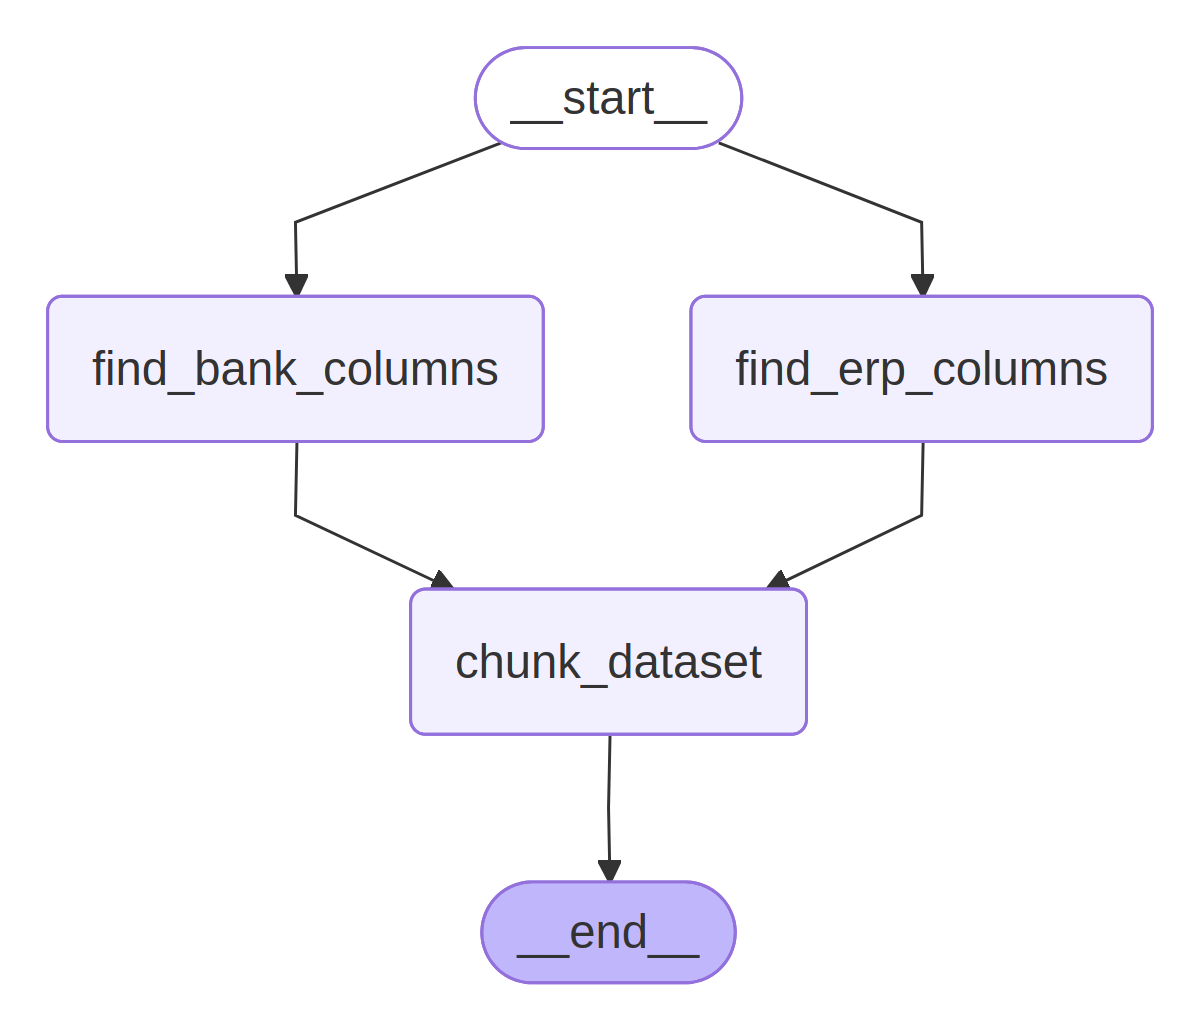

In [11]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [12]:
# Run with both datasets
initial_state = {
    "erp_data": "Dataset/Pubali # 41774-ERP.csv",
    "bank_data": "Dataset/Pubali # 41774.csv"
}
result = workflow.invoke(initial_state)

print("Bank Columns:", result["bank_columns"])
print("ERP Columns:", result["erp_columns"])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Bank Columns: transaction_date='TRN DATE' debit='DEBIT' credit='CREDIT'
ERP Columns: transaction_date='Date' debit='Debit' credit='Credit'


In [13]:
bank_columns = result["bank_columns"]
erp_columns = result["erp_columns"]

In [14]:
# Option 1: Access each value individually
transaction_date = bank_columns.transaction_date
debit = bank_columns.debit
credit = bank_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

TRN DATE 
 DEBIT 
 CREDIT


In [15]:
# Option 1: Access each value individually
transaction_date = erp_columns.transaction_date
debit = erp_columns.debit
credit = erp_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

Date 
 Debit 
 Credit


In [16]:
len(result["bank_chunk_data"])

11

In [17]:
result["bank_chunk_data"][0]

,TRN DATE,DEBIT,CREDIT
0,2025-02-07,NaN,"16,000.00"
1,2025-02-07,NaN,"16,000.00"
2,2025-02-07,NaN,"20,000.00"
3,2025-02-07,NaN,"100,000.00"
4,2025-02-07,NaN,"30,000.00"
...,...,...,...
83,2025-02-07,NaN,"10,000.00"
84,2025-02-07,NaN,"5,000.00"
85,2025-02-07,NaN,"50,000.00"
86,2025-02-07,NaN,"114,500.00"


In [18]:
result["erp_chunk_data"][0]

,Date,Debit,Credit
0,2025-07-01,6160.0,NaN
1,2025-07-01,11000.0,NaN
2,2025-07-02,50000.0,NaN
3,2025-07-02,8000.0,NaN
4,2025-07-02,20000.0,NaN
...,...,...,...
147,2025-07-03,100000.0,NaN
148,2025-07-03,6600.0,NaN
149,2025-07-03,71000.0,NaN
150,2025-07-03,12000.0,NaN
